In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import warnings  
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression,LogisticRegression
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.metrics import confusion_matrix
import time
import scikitplot as skplt
import itertools
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/plenoi/Clinic/master/ultima_all_clean.csv')
df = df.set_index('hn')
df.head()

,age,parity,hiv,menopaus,disease,surgery,conization,OPDsize,appearance,stage,...,nodeyiel,RHlvsi,depth,size,utmet,vgmargin,vgmet,pelvicme,pmmet,adnmet
hn,,,,,,,,,,,,,,,,,,,,,
2631840,52,3,0.0,0.0,1,1,0.0,5.0,4.0,5.0,...,21.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
2633481,32,2,0.0,0.0,0,1,0.0,5.0,1.0,5.0,...,11.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0,0.0,2.0
2634477,52,2,0.0,0.0,0,0,0.0,5.0,NaN,5.0,...,35.0,6.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2633633,38,2,0.0,0.0,0,0,0.0,2.0,1.0,4.0,...,20.0,16.0,3.0,3.8,0.0,0.0,0.0,0.0,0.0,2.0
2630496,55,3,0.0,1.0,0,0,1.0,0.0,5.0,4.0,...,17.0,9.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [3]:
df.isnull().sum(axis=0)

age             0
parity          0
hiv             4
menopaus        1
disease         0
surgery         0
conization      5
OPDsize        17
appearance    101
stage          24
pchemo          1
Wardsize      145
finalhisto     10
nodeyiel       12
RHlvsi        366
depth         489
size          114
utmet          98
vgmargin       96
vgmet          97
pelvicme        1
pmmet          94
adnmet          7
dtype: int64

In [4]:
df_clean_column = df.drop(['appearance','Wardsize','RHlvsi','depth','nodeyiel','vgmargin','pelvicme','adnmet'],axis=1)
df_clean_column.isnull().sum(axis=0)

age             0
parity          0
hiv             4
menopaus        1
disease         0
surgery         0
conization      5
OPDsize        17
stage          24
pchemo          1
finalhisto     10
size          114
utmet          98
vgmet          97
pmmet          94
dtype: int64

In [5]:
df_clean = df_clean_column.dropna(axis=0)

In [6]:
pm_class = np.unique(df_clean['pmmet'])
pm_class

array([0., 1.])

In [7]:
pm_value = [sum(df_clean['pmmet'] == pm_class[0]),sum(df_clean['pmmet'] == pm_class[1])]
pm_value

[1278, 277]

In [8]:
y = df_clean['pmmet'].values
X = df_clean.drop(['pmmet'],axis=1).values

In [10]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=1)
X_res,y_res = sm.fit_resample(X,y)

In [11]:
from sklearn.model_selection import train_test_split
X,X_res,y,y_res = train_test_split(X,y,test_size=0.2,random_state=0)

In [12]:
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler(feature_range=(0,1)) #สร้าง Model และแปลงค่าใหอยู่ในช่วง 0-1
scaler.fit(X)
X_train_norm = scaler.transform(X)
X_test_norm = scaler.transform(X_res)

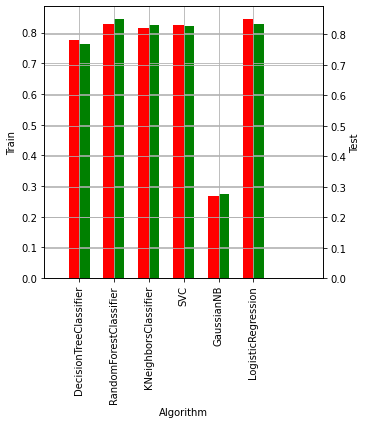

In [36]:
warnings.filterwarnings('ignore')
# Baseline - comparing model accuracy using all features across classifiers 
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    GaussianNB(),
    LogisticRegression()
    ]


# Naive Train Accuracy
algo = []
scores = []
for clf in classifiers:
    algo.append(clf.__class__.__name__)
    scores.append(cross_val_score(clf,X_train_norm,y, cv=10).mean())
warnings.filterwarnings('ignore')
Naivescore_df_Train = pd.DataFrame({'Algorithm': algo, 'Score': scores}).set_index('Algorithm')


# Naive Test Accuracy

algo = []
scores = []

for clf in classifiers:
    clf = clf.fit(X_train_norm, y)
    y_pred = clf.predict(X_test_norm)
    algo.append(clf.__class__.__name__)
    scores.append(accuracy_score(y_pred, y_res))
warnings.filterwarnings('ignore')
Naivescore_df_Test  = pd.DataFrame({'Algorithm': algo, 'Score': scores}).set_index('Algorithm')

# Bar plot between Train and Test Accuracy
fig = plt.figure(figsize=(5,5)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as a
width = .3

Naivescore_df_Train.Score.plot(kind='bar',color='green',ax=ax,width=width, position=0)
Naivescore_df_Test.Score.plot(kind='bar',color='red', ax=ax2,width = width,position=1)

ax.grid(None, axis= 'both')
ax2.grid(None)

ax.set_ylabel('Train')
ax2.set_ylabel('Test')

ax.set_xlim(-1,7)
plt.show()

In [37]:
# Feature selection using Random Forest Classifier

# Bagged decision trees for feature importance- embedded method
Rtree_clf = RandomForestClassifier()
Rtree_clf = Rtree_clf.fit(X_train_norm,y)
model = SelectFromModel(Rtree_clf, prefit=True)
RF_tree_featuresTrain= X_train_norm[:, model.get_support()]
RF_tree_featuresTest = X_test_norm[:, model.get_support()]
warnings.filterwarnings('ignore')


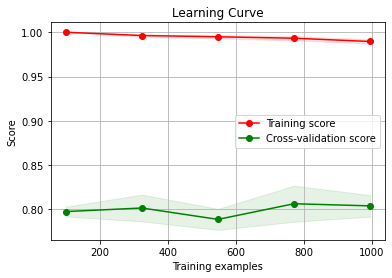

In [38]:
skplt.estimators.plot_learning_curve(Rtree_clf,RF_tree_featuresTrain,y)

Optimal number of features : 1


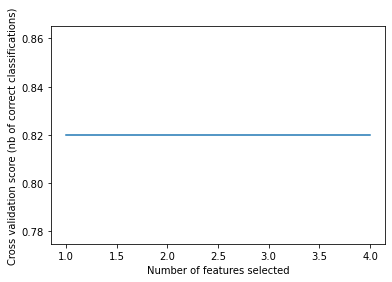

In [39]:
# The "accuracy" scoring is proportional to the number of correct classifications

# Before we apply RFE we need to know the optimal number of features. Hence RFECV crossvalidation technique is used to find 
# the optimal number of features based on the accuracy score in the training set. 

# Applying RFECV with svm classifier
svc=SVC(kernel="linear")
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2), # Stratified fold inorder to reduce bias
              scoring='accuracy')
rfetrain=rfecv.fit(RF_tree_featuresTrain, y)
print('Optimal number of features :', rfecv.n_features_)


# Plot showing the Cross Validation score
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [30]:
X_train_norm.shape

(1244, 14)

In [31]:
X_test_norm.shape

(311, 14)

In [32]:
y.shape

(1244,)

In [33]:
y_res.shape

(311,)

In [41]:
# Applying RFE with optimal number of features
rfe = RFE(estimator=svc, n_features_to_select=rfecv.n_features_, step=1)
rfe = rfe.fit(RF_tree_featuresTrain, y)

rfe_train=RF_tree_featuresTrain[:, rfe.get_support()]
rfe_test=RF_tree_featuresTest[:, rfe.get_support()]


# Checking the Accuracy after rfe
# Train Accuracy
print("Train Accuracy:",cross_val_score(svc,rfe_train,y, cv=10).mean())
# Test Accuracy
scv = svc.fit(rfe_train, y)
y_pred = scv.predict(rfe_test)
print("Test Accuracy:",accuracy_score(y_pred, y_res))

Train Accuracy: 0.8199483870967741
Test Accuracy: 0.8295819935691319


In [42]:
# Variance threshold
selector = VarianceThreshold(0.95*(1-.95))
varsel=selector.fit(rfe_train)
rfe_train[:, varsel.get_support()].shape
# 55
vartrain=rfe_train[:, varsel.get_support()]
vartest=rfe_test[:, varsel.get_support()]

# Checking the Accuracy after Variance threshold
# Train Accuracy
print("Train Accuracy:",cross_val_score(svc,vartrain,y, cv=10).mean())

# Test Accuracy
scv = svc.fit(vartrain, y)
y_pred = scv.predict(vartest)
print("Test Accuracy:",accuracy_score(y_pred, y_res))

Train Accuracy: 0.8199483870967741
Test Accuracy: 0.8295819935691319


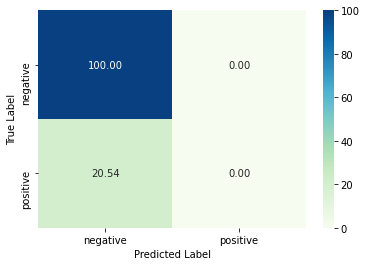

In [49]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_res,y_pred) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt=".2f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_res, y_pred, target_names=target_names))

NameError: name 'y_predict' is not defined